In [14]:
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
import rasterio
import rasterio.mask
from rasterio.plot import show
import numpy as np
import numpy.ma as ma
from rasterio.windows import from_bounds
from rasterio.warp import calculate_default_transform, reproject, Resampling
import geopandas as gpd
import os
import shutil
from zipfile import ZipFile


In [5]:
all_geom = gpd.read_file('./project_files/farm_simple.geojson')
pad_geom = all_geom[all_geom.name == 'East 18 South']
pad_geom_m = pad_geom.to_crs('epsg:32616')

In [31]:
with rasterio.open('./data/S2A_MSIL2A_20200418T164901_N0214_R026_T16TCM_20200418T210937.SAFE/GRANULE/L2A_T16TCM_A025191_20200418T165421/IMG_DATA/R10m/T16TCM_20200418T164901_B04_10m.jp2', 'r') as b4:
    b4_img, b4_transform = rasterio.mask.mask(b4, pad_geom_m.geometry, crop=True)
    b4_out_meta = b4.meta.copy()
    b4_out_meta.update({'driver': 'GTiff',
                     'height': b4_img.shape[1],
                     'width': b4_img.shape[2],
                     'transform': b4_transform})
    red = b4_img.astype(float)

with rasterio.open('B4_masked.tiff', 'w', **b4_out_meta) as dest:
    dest.write(b4_img)

with rasterio.open('./data/S2A_MSIL2A_20200418T164901_N0214_R026_T16TCM_20200418T210937.SAFE/GRANULE/L2A_T16TCM_A025191_20200418T165421/IMG_DATA/R10m/T16TCM_20200418T164901_B08_10m.jp2', 'r') as b8:
    b8_img, b8_transform = rasterio.mask.mask(b8, pad_geom_m.geometry, crop=True)
    b8_out_meta = b8.meta.copy()
    b8_out_meta.update({'driver': 'GTiff',
                        'height': b8_img.shape[1],
                        'width': b8_img.shape[2],
                        'transform': b8_transform})
    nir = b8_img.astype(float)

with rasterio.open('B8_masked.tiff', 'w', **b8_out_meta) as dest:
    dest.write(b8_img)


ndvi = (nir - red)/(nir + red)
b4_out_meta.update({'dtype': rasterio.float64})

with rasterio.open('NDVI_masked.tiff', 'w', **b4_out_meta) as dest:
    dest.write(ndvi.astype(rasterio.float64))

/Users/MarkNyberg/PycharmProjects/sentinel_processing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


In [45]:
print(np.nanmean(ndvi))
print(np.nanmax(ndvi))
print(np.nanmin(ndvi))

0.3608108486820853
0.9284578696343402
-0.04655493482309125


In [9]:
with rasterio.open('./project_files/evi_masked.tiff') as src:
    evi_img, _ = rasterio.mask.mask(src, pad_geom_m.geometry, crop=True)
    count = np.count_nonzero(evi_img)

In [6]:
new_geom = all_geom.to_crs('epsg:32616')
new_geom.area, new_geom.name

(0     239352.018256
 1       4877.582653
 2       8655.398718
 3       4480.266018
 4       7337.427826
 5       6666.291519
 6       6910.027928
 7       6389.330105
 8       6523.973234
 9       5754.268307
 10      6230.595710
 11      5462.173002
 12      6083.058236
 13      4377.462178
 14      5273.991024
 15      4479.148375
 16      4739.016965
 17      3719.745478
 18      7137.874739
 19      4639.140725
 20      2914.787679
 21      1971.950981
 22      5398.389300
 23      7827.983507
 24     17633.188104
 25     21510.012217
 dtype: float64,
 0     Farm boundary
 1         Paddock 1
 2         Paddock 2
 3         Paddock 3
 4         Paddock 4
 5         Paddock 5
 6         Paddock 6
 7         Paddock 7
 8         Paddock 8
 9         Paddock 9
 10       Paddock 10
 11       Paddock 11
 12       Paddock 12
 13       Paddock 13
 14       Paddock 14
 15       Paddock 15
 16       Paddock 16
 17       Paddock 17
 18       Paddock 18
 19       Paddock 19
 20       Paddock

In [6]:
pad_mask = gpd.read_file('../KMZs/votm/farm_simple.geojson')
pad_box = pad_mask[pad_mask.name == 'votm farm padded']

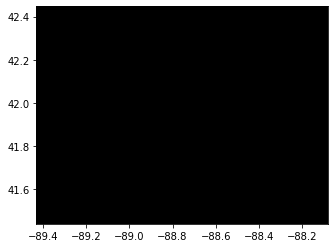

In [15]:
with rasterio.open('TCI.tiff', 'r') as infile:
    show(infile)